In [147]:
# Imports
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import netCDF4 as nc
import xarray as xr
import matplotlib.dates as mdates
from matplotlib import style

## Parte 2.3: Series temporales de anomalías.
Evaluación de las series temporales de anomalías en distintas regiones para el periodo completo. Calcula la anomalía mensual (a cada mes de cada año hay que restarle la media de ese mes para todos los años) en 3 regiones diferentes:
- Pacífico (17090ºW, 5ºS5ºN)
- Atlántico (70ºW0, 0ºN60ºN)
- Índico (40110ºE, 30ºS25ºN)

Representa las series temporales promediando los datos regionales en cada región. Comenta los resultados.


#### Lectura del fichero con netCDF4:
Nota: se trata de un fichero con datos mensuales desde 1870 hasta 2019

In [148]:
# Lectura del fichero
file=u'./data/HadISST1_sst_1870-2019.nc' 
fil = nc.Dataset(file,'r') # Leemos con netCDF4
fil.variables.keys()

dict_keys(['longitude', 'latitude', 'time', 'sst'])

In [149]:
'''
path = u'c:/Users/digar7/OneDrive - Universidad de Oviedo/Documento/MASTER/Análisis/Práctica 1/data/'
file = 'HadISST1_sst_1870-2019.nc' 
ds = xr.open_dataset(path + file)
'''

"\npath = u'c:/Users/digar7/OneDrive - Universidad de Oviedo/Documento/MASTER/Análisis/Práctica 1/data/'\nfile = 'HadISST1_sst_1870-2019.nc' \nds = xr.open_dataset(path + file)\n"

In [150]:
# Recogemos cada variable y pasamos los tiempos a formato de fechas
on = fil.variables['longitude'][:]
lat = fil.variables['latitude'][:]
tiempo = fil.variables['time'] # Sin los dos puntos para que sea variable ncdf, con ellos es un masked array
sst = fil.variables['sst'][:]

tiempodates = nc.num2date(tiempo[:],tiempo.units,only_use_cftime_datetimes=False,only_use_python_datetimes=True) # Cambiamos el tiempo a un array de fechas Dia-Mes-Año
# Los últimos 2 parámetros que le paso a la función son para que guarde las fechas en el formato datetime de python (que funciona con pyplot), en vez de en cftime


#### Función de cálculo de las series de anomalías:

In [151]:
def regional_monthly_anomalies(var:np.ndarray,lonmin:float,lonmax:float,latmin:float,latmax:float,standardized=False):
    '''Función para calcular las anomalias mesuales de una cierta variable en una cierta región geográfica, a partir de datos mensuales 
    a distintas longitud y latitud.

    Entradas:
    -> var: el array con los datos de la variable, en forma (tiempo,latitud,longitud)
    -> lonmin: longitud mínima de la región
    -> lonmax: longitud máxima de la región
    -> latmin: latitud mínima de la región
    -> latmax: latitud máxima de la región
    -> standardized: booleano, si se quieren considerar anomalias estandarizadas, fijar a True
    
    Salida: array de anomalías mensuales de la variable, en forma (año,mes)
    '''
    nt, nlat, nlon = sst.shape  # Cojo los números de cada coordenada de la forma del array var
    nm = 12                     # Número de meses
    ny = int(nt/nm)             # Número de años = tiempos/(12 meses)
    region_var = var[:,:,(lon>lonmin)&(lon<lonmax)][:,(lat>latmin)&(lat<latmax),:].mean(axis=(1,2)) # Selecionamos la región y promediamos
    region_var = np.reshape(region_var,[ny,nm]) # Damos forma al array 1d para que sea 2d con forma (años,meses)

    regional_month_anom = np.zeros_like(region_var) # Creamos un array de ceros como el del valor de la variable en la región
    if standardized == False:   # Si no se quiere que sea estandarizada
        for mes in range(12):   # Recorremos los meses
            regional_month_anom[:,mes] = region_var[:,mes]-region_var[:,mes].mean() # Anomalía= Valor mesual en un año - Media del mes
    if standardized == True:    # Si se quiere que sea estandarizada, dividimos por la desviación estandar
        for mes in range(12):
            regional_month_anom[:,mes] = (region_var[:,mes]-region_var[:,mes].mean())/region_var[:,mes].std()
    
    return regional_month_anom

#### Cambio de los parámetros de la representación:

In [152]:
plt.style.use('seaborn') # Estilo general

font = {'size'   : 14}
plt.rc('font', **font) # Tamaño generico de fuentes
parameters = {'xtick.labelsize':14,
              'ytick.labelsize':14,
              'axes.labelsize':14,
              'axes.labelweight':'bold',
              'axes.titleweight':'bold',
              'axes.titlesize':18,
              'legend.fontsize':15,
              'legend.frameon':True,
              'legend.facecolor':'w',
              'legend.title_fontsize':16,
              'ytick.major.size': 3.5,
              'ytick.major.width': 0.8,
              'xtick.major.size': 3.5,
              'xtick.major.width': 0.8,  
              'axes.linewidth':1,
              'axes.edgecolor':'grey',
              'xtick.color':'grey',
              'xtick.labelcolor':'k',
              'ytick.color':'grey',
              'ytick.labelcolor':'k'}
plt.rcParams.update(parameters)

#### Anomalías no estandarizadas:

Text(0.5, 1.0, 'Anomalías regionales de la temperatura de la superficie del oceano (SST)')

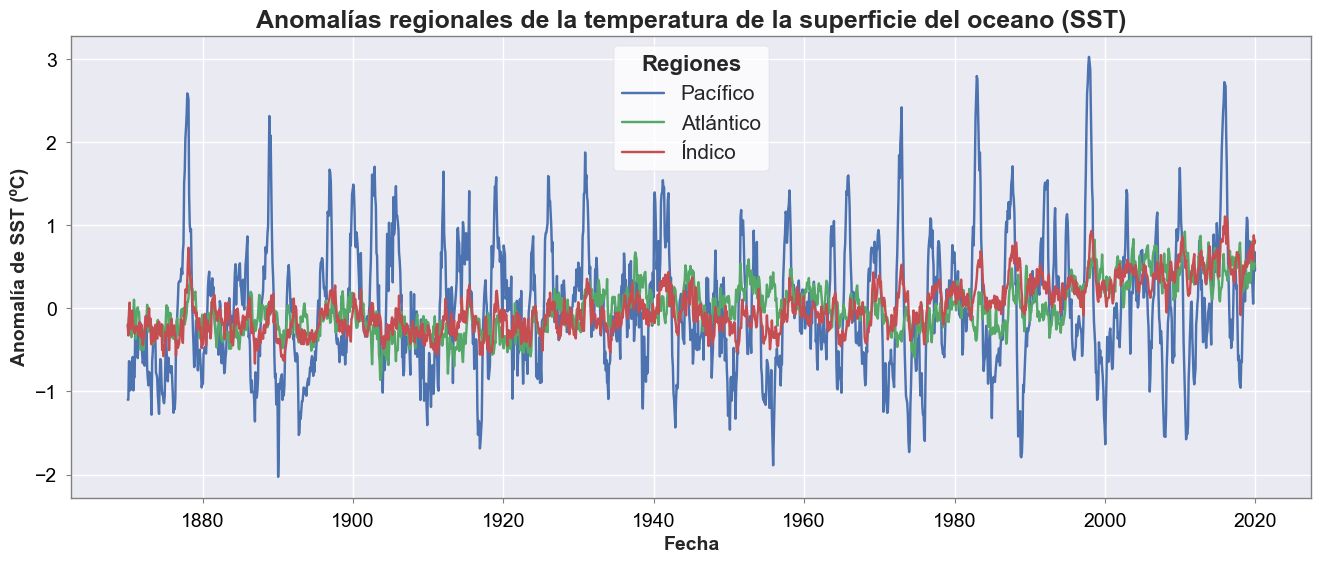

In [153]:
# Cálculo de las anomalías para cada una de las regiones
pacific_anom = regional_monthly_anomalies(sst,-170,-90,-5,5).ravel() # ravel() para que lo ponga como un array 1d
atlantic_anom = regional_monthly_anomalies(sst,-70,0,0,60).ravel()
indic_anom = regional_monthly_anomalies(sst,40,110,-30,25).ravel()


fig,ax = plt.subplots(figsize = (16,6))
ax.plot(tiempodates,pacific_anom,label='Pacífico')
ax.plot(tiempodates,atlantic_anom,label='Atlántico')
ax.plot(tiempodates,indic_anom,label='Índico')
ax.legend(title='Regiones',title_fontproperties={'weight':'bold'}) # Leyenda con título
ax.set_xlabel('Fecha')
ax.set_ylabel('Anomalía de SST (ºC)')
ax.set_title('Anomalías regionales de la temperatura de la superficie del oceano (SST)')
#fig.savefig('anom.png',dpi=600,facecolor='w')

#### Anomalías estandarizadas:

Text(0.5, 1.0, 'Anomalías estandarizadas regionales de la temperatura de la superficie del oceano (SST)')

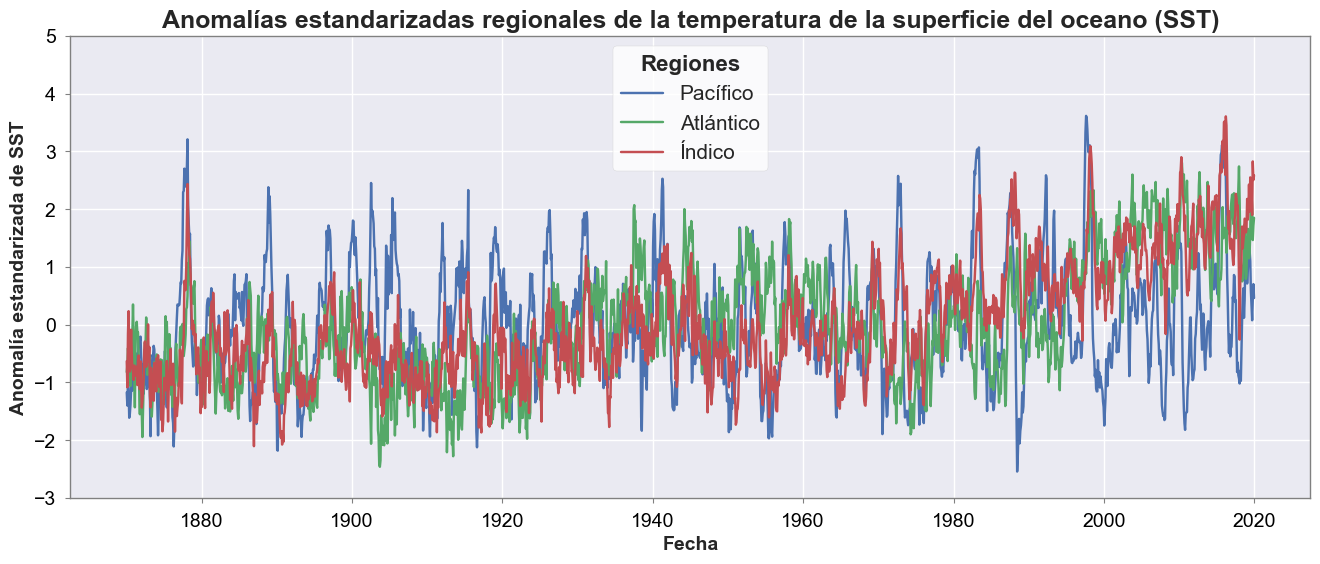

In [154]:
# Cálculo de las anomalías estandarizadas para cada una de las regiones
pacific_anom = regional_monthly_anomalies(sst,-170,-90,-5,5,standardized=True).ravel() # ravel() para que lo ponga como un array 1d
atlantic_anom = regional_monthly_anomalies(sst,-70,0,0,60,standardized=True).ravel()
indic_anom = regional_monthly_anomalies(sst,40,110,-30,25,standardized=True).ravel()

fig,ax = plt.subplots(figsize = (16,6))
ax.plot(tiempodates,pacific_anom,label='Pacífico')
ax.plot(tiempodates,atlantic_anom,label='Atlántico')
ax.plot(tiempodates,indic_anom,label='Índico')
ax.legend(title='Regiones',title_fontproperties={'weight':'bold'}) # Leyenda con título
ax.set_xlabel('Fecha')
ax.set_ylabel('Anomalía estandarizada de SST')
ax.set_ylim(-3,5) # Para que quepa mejor la leyenda
ax.set_title('Anomalías estandarizadas regionales de la temperatura de la superficie del oceano (SST)')
#fig.savefig('anom_std.png',dpi=600,facecolor='w')